In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

In [2]:
preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
print(preDouble)

\\iobsdc01\SharedDocs\SEER_MEDICARE\SEER_MEDICARE_STAGING


In [3]:
import pickle
fileObject = open('control_indicies.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices = list(b)

In [4]:
import pickle
fileObject = open('treatment_indicies.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices = list(b)

In [5]:
print(len(controlindices), len(treatmentindices))

1031 1031


In [6]:
dg = pd.read_pickle('goodindices_costofcare_outsaf.pickle')

Dg contains the dataframe created in costofcare.ipynb, that grabs all the rows of the outsaf claims files corresonding to controlindices and treatmentindices.

Now we need to add in the modx1 information as well as the site1 information from the pedsf files.

In [7]:
krazykols = ['patient_id','claim_from_date',
            'link_num','rec_count','hcpcs','tot_chrg','tot_line',
            'seg_line']

dg[krazykols].head(30)

,patient_id,claim_from_date,link_num,rec_count,hcpcs,tot_chrg,tot_line,seg_line
0,0244410011,12192006,1042840,1,NaN,5242.49,8,8
1,0244410011,12192006,1042840,2,NaN,5242.49,8,8
2,0244410011,12192006,1042840,3,NaN,5242.49,8,8
3,0244410011,12192006,1042840,4,NaN,5242.49,8,8
4,0244410011,12192006,1042840,5,NaN,5242.49,8,8
5,0244410011,12192006,1042840,6,66984,5242.49,8,8
6,0244410011,12192006,1042840,7,NaN,5242.49,8,8
7,0244410011,12192006,1042840,8,NaN,5242.49,8,8
8,0244410011,6242006,1285544,1,NaN,1142.80,8,8
9,0244410011,6242006,1285544,2,80048,1142.80,8,8


In [8]:
dg['claim_from_date'] = dg['claim_from_date'].apply(str)
dg['claim_from_date'] = dg['claim_from_date'].apply(lambda x: x.rjust(8, '0'))

In [9]:
dg['claim_from_date'] = pd.to_datetime(dg['claim_from_date'], format='%m%d%Y')
dg['claim_from_date_day'] = dg['claim_from_date'].dt.day
dg['claim_from_date_month'] = dg['claim_from_date'].dt.month
dg['claim_from_date_year'] = dg['claim_from_date'].dt.year

## Now need to load in the stuff from the pedsf big file.

We need to only compute the total cost of care for each patient_id, where the 'claim_from_date' is later in time than the diagnosis date.

In [10]:
df = pd.read_pickle('dfpedsfFirsts.pickle')

In [11]:
df = df.set_index('patient_id',drop=False)

In [13]:
goodindices = controlindices + treatmentindices
print(len(goodindices),len(controlindices),len(treatmentindices))

2062 1031 1031


In [14]:
df_all_good_indices = df.loc[goodindices].copy()

In [15]:
df_all_good_indices.yrdx1.head(10)

patient_id
8835051335    2009
8880063314    2008
8865006343    2007
8833080450    2010
8887079350    2006
8855021414    2011
8834065023    2008
8876047420    2010
8840048462    2011
8874062373    2008
Name: yrdx1, dtype: int64

In [16]:
df_all_good_indices.modx1.head(10)

patient_id
8835051335    Apr
8880063314    Dec
8865006343    Jul
8833080450    Jul
8887079350    Jun
8855021414    Apr
8834065023    Oct
8876047420    Jan
8840048462    Jul
8874062373    Apr
Name: modx1, dtype: object

In [18]:
df_all_good_indices.site1.value_counts()

Prostate gland               1854
Choroid                        86
Upper lobe, lung               62
Lower lobe, lung               14
Frontal lobe                   10
Cerebral meninges               6
Lower third of esophagus        6
Lung, NOS                       4
Parotid gland                   4
Parietal lobe                   4
Acoustic nerve                  2
Cervical esophagus              2
Middle third of esophagus       2
Ciliary body                    2
Main bronchus                   2
Temporal lobe                   2
Name: site1, dtype: int64

In [19]:
del df

In [20]:
monthdict = {'Jan': '01',
            'Feb': '02',
            'Mar': '03',
            'Apr': '04',
            'May': '05',
            'Jun': '06',
            'Jul': '07',
            'Aug': '08',
            'Sep': '09',
            'Oct': '10',
            'Nov': '11',
            'Dec': '12'}

In [21]:
df_all_good_indices['month1'] = df_all_good_indices['modx1'].replace(monthdict)
df_all_good_indices['month1'].head()


patient_id
8835051335    04
8880063314    12
8865006343    07
8833080450    07
8887079350    06
Name: month1, dtype: object

In [22]:
df_all_good_indices['month1'].isnull().sum()

8

# We need to remove from treatmentindices and controlindices any patient_ids that correspond to either a key or value of the d_c_t dictionary that corresponds to any of the 8 patient_ids indicated above.

In [24]:
d_t_c = dict(zip(treatmentindices, controlindices))
d_c_t = dict(zip(controlindices, treatmentindices))

In [25]:
goodcols_eval = ['m_sex','marst1','srace','nhiade','grade1','site1','lat1','lat_1','lng_1','histrec1',
            'modx1','birthyr','agedx1','yrdx1']

In [27]:
df_all_good_indices[goodcols_eval].loc[[controlindices[0],treatmentindices[0]]]

,m_sex,marst1,srace,nhiade,grade1,site1,lat1,lat_1,lng_1,histrec1,modx1,birthyr,agedx1,yrdx1
patient_id,,,,,,,,,,,,,,
8835051335,Male,Married (including common law),Black,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,Not a paired site,33.9533,-117.396,8140-8398: adenomas and adenocarcinomas,Apr,1939,69,2009
8893000334,Male,Married (including common law),Black,Non-Spanish-Hispanic-Latino,Grade II; grade ii; grade 2; moderately differ...,Prostate gland,Not a paired site,34.9592,-116.419,8140-8398: adenomas and adenocarcinomas,Apr,1939,69,2009


In [29]:
bad_month_indices_filter = df_all_good_indices['month1'].isnull()

In [31]:
df_all_good_indices[bad_month_indices_filter].month1

patient_id
8821004315    NaN
8871012452    NaN
8850026350    NaN
8894012311    NaN
8840093440    NaN
8843057443    NaN
8860084330    NaN
8891049399    NaN
Name: month1, dtype: object

## In order to do the paired tests, we need to elminate they key-value pairs in d_t_c, where any of the above 8 patient_ids appear as either a key or a value.

In [33]:
to_drop = list(df_all_good_indices[bad_month_indices_filter].month1.index)
print(to_drop)

['8821004315', '8871012452', '8850026350', '8894012311', '8840093440', '8843057443', '8860084330', '8891049399']


In [35]:
to_drop[0] in d_t_c.keys()

False

In [36]:
to_drop[0] in d_t_c.values()

True

In [43]:
d_c_t[to_drop[3]] in to_drop

True

In [47]:
to_drop[7] in d_t_c.keys()

True

```to_drop[4], to_drop[5], to_drop[6], to_drop[7]``` are all in d_t_c.keys().
So we just need to drop those key-value pairs. OK

In [48]:
for i in (4,5,6,7):
    del d_t_c[to_drop[i]]

In [49]:
goodtreatmentindices = d_t_c.keys()
goodcontrolindices = d_t_c.values()
print(len(goodtreatmentindices), len(goodcontrolindices))

1027 1027


In [51]:
df_all_good_indices = df_all_good_indices.loc[list(goodcontrolindices) + list(goodtreatmentindices)]

In [52]:
df_all_good_indices['month1'].isnull().sum()  # should be zero

0

In [53]:
df_all_good_indices['yrdx_plus_modx'] = df_all_good_indices.yrdx1.astype('str') + df_all_good_indices.month1.astype('str')

In [54]:
df_all_good_indices['yrdx_plus_modx'].head()

patient_id
8814093461    201007
8801085324    200807
2310165000    200709
8838066384    200812
8813094341    200608
Name: yrdx_plus_modx, dtype: object

In [55]:
# g['claim_from_date'] = pd.to_datetime(dg['claim_from_date'], format='%m%d%Y')

df_all_good_indices['yrdx_plus_modx'] = pd.to_datetime(df_all_good_indices['yrdx_plus_modx'], 
                                                      format='%Y%m')

In [56]:
df_all_good_indices['yrdx_plus_modx'].head(5)

patient_id
8814093461   2010-07-01
8801085324   2008-07-01
2310165000   2007-09-01
8838066384   2008-12-01
8813094341   2006-08-01
Name: yrdx_plus_modx, dtype: datetime64[ns]

In [57]:
df_all_good_indices['site1'].head(5)

patient_id
8814093461      Prostate gland
8801085324      Prostate gland
2310165000    Upper lobe, lung
8838066384      Prostate gland
8813094341      Prostate gland
Name: site1, dtype: object

In [58]:
dg = dg.set_index('patient_id',drop=False)

In [59]:
dh = dg.loc[df_all_good_indices.index]

In [60]:
dh['yrdx_plus_modx'] = df_all_good_indices['yrdx_plus_modx']
dh['site1'] = df_all_good_indices['site1']

We only care about the costs for claims where ```claim_from_date``` is greater than or equal to ```yrdx_plus_modx```

In [64]:
krazykols = ['patient_id','claim_from_date','yrdx_plus_modx',
            'link_num','rec_count','hcpcs','tot_chrg','tot_line',
            'seg_line','site1']

dh[krazykols].head(30)

,patient_id,claim_from_date,yrdx_plus_modx,link_num,rec_count,hcpcs,tot_chrg,tot_line,seg_line,site1
patient_id,,,,,,,,,,
8814093461,NaN,NaT,2010-07-01,NaN,NaN,NaN,NaN,NaN,NaN,Prostate gland
8801085324,8801085324,2012-12-03,2008-07-01,4685836.0,1.0,78306,1899.00,3.0,3.0,Prostate gland
8801085324,8801085324,2012-12-03,2008-07-01,4685836.0,2.0,A9503,1899.00,3.0,3.0,Prostate gland
8801085324,8801085324,2012-12-03,2008-07-01,4685836.0,3.0,NaN,1899.00,3.0,3.0,Prostate gland
8801085324,8801085324,2013-06-14,2008-07-01,4886864.0,1.0,36415,659.05,6.0,6.0,Prostate gland
8801085324,8801085324,2013-06-14,2008-07-01,4886864.0,2.0,80053,659.05,6.0,6.0,Prostate gland
8801085324,8801085324,2013-06-14,2008-07-01,4886864.0,3.0,82043,659.05,6.0,6.0,Prostate gland
8801085324,8801085324,2013-06-14,2008-07-01,4886864.0,4.0,83036,659.05,6.0,6.0,Prostate gland
8801085324,8801085324,2013-06-14,2008-07-01,4886864.0,5.0,85027,659.05,6.0,6.0,Prostate gland


In [63]:
dh[krazykols].dropna().shape

(280062, 10)

In [65]:
(dh.claim_from_date >= dh.yrdx_plus_modx).sum()

296588

In [66]:
dh.shape


(346507, 36)

In [67]:
dh = dh[(dh.claim_from_date >= dh.yrdx_plus_modx)]

In [68]:
dhcontrol = dh.loc[goodcontrolindices]
dhtreatment = dh.loc[goodtreatmentindices]


In [70]:
dh[krazykols].loc[[list(goodcontrolindices)[0],list(goodtreatmentindices)[0]]]

,patient_id,claim_from_date,yrdx_plus_modx,link_num,rec_count,hcpcs,tot_chrg,tot_line,seg_line,site1
patient_id,,,,,,,,,,
8814093461,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8808051451,8808051451,2010-10-04,2010-07-01,4797169.0,1.0,36415,63562.00,28.0,28.0,Prostate gland
8808051451,8808051451,2010-10-04,2010-07-01,4797169.0,2.0,84153,63562.00,28.0,28.0,Prostate gland
8808051451,8808051451,2010-10-04,2010-07-01,4797169.0,3.0,77290,63562.00,28.0,28.0,Prostate gland
8808051451,8808051451,2010-10-04,2010-07-01,4797169.0,4.0,77290,63562.00,28.0,28.0,Prostate gland
8808051451,8808051451,2010-10-04,2010-07-01,4797169.0,5.0,77295,63562.00,28.0,28.0,Prostate gland
8808051451,8808051451,2010-10-04,2010-07-01,4797169.0,6.0,77300,63562.00,28.0,28.0,Prostate gland
8808051451,8808051451,2010-10-04,2010-07-01,4797169.0,7.0,77321,63562.00,28.0,28.0,Prostate gland
8808051451,8808051451,2010-10-04,2010-07-01,4797169.0,8.0,77334,63562.00,28.0,28.0,Prostate gland


Sometimes the corresponding control to a given treatment will not have any entries in the outsaf file. OK.

In [71]:
def make_hcpcs_dataframe(filehcpcs='OPTUM_HCPCS_BASE_2016_01_update.TXT'):
    """Make the dataframe corresponding to the hcpcs codes."""
    dfhcpcs = pd.read_fwf(filehcpcs,skip_blank_lines=True,header=None,widths=[5,2084],
        names=['code','description'])
    return dfhcpcs

In [72]:
def make_cpc_dataframe(filecpc = 'OPTUM_CPC_BASE_2016_01.TXT'):
    """Make the dataframe corresponding to the cpc (cpt) codes."""
    dfcpc = pd.read_fwf(filecpc,header=None,skip_blank_lines=True,
                     widths=[5,100],names=['code','description'])
    return dfcpc

In [73]:
def make_code_dataframe():
    """Combine the level1 and level2 code information into a single dataframe."""
    df1 = make_hcpcs_dataframe()
    df2 = make_cpc_dataframe()
    dftotal = df1[['code','description']].append(df2[['code','description']])
    return dftotal

In [74]:
dfcodes = make_code_dataframe()

In [75]:
dfcodes.head()

,code,description
0,A0021,AMB SRVC OTSD STATE-MILE TRANSPORT AMB SERVICE...
1,A0080,NONEMERG TRNSPRT VOLUN NOT VESTED NONEMERG TR...
2,A0090,NONEMERG TRNSPRT IND W/VESTED INT NONEMERG TR...
3,A0100,NONEMERGENCY TRANSPORTATION; TAXI NONEMERGENC...
4,A0110,NONEMERG TRNSPRT&BUS INTERSTATE NONEMERG TR...


In [80]:
def hcpcs_description_trans(df,dfhcpcs12,columnname):
    """Takes the dataframe df and the columnname as a string and adds
    a column containing the long description to df using the description string
    in dfhcpcs12."""
    dfhuh = pd.merge(df[[columnname]], dfhcpcs12,
                    left_on=columnname, right_on='code',how='left')
    df[columnname + '_description'] =  dfhuh['description']
    del dfhuh

In [81]:
hcpcs_description_trans(dhcontrol,dfcodes,'hcpcs')

In [82]:
list(dhcontrol.columns)

['casereg',
 'patient_id',
 'claim_from_date',
 'claim_through_date',
 'fac_type',
 'freq_cd',
 'pmt_amt',
 'tot_chrg',
 'tot_line',
 'seg_line',
 'e1dgnscd',
 'opsrvtyp',
 'center',
 'hcpcs',
 'mf1',
 'mf2',
 'mf3',
 'charge',
 'revncvr',
 'year',
 'link_num',
 'tot_seg',
 'seg_num',
 'rec_count',
 'prvdrpmt',
 'edgnsd1',
 'edgnsd2',
 'edgnsd3',
 'prcdr_cd1',
 'prcdr_cd2',
 'prcdr_cd3',
 'claim_from_date_day',
 'claim_from_date_month',
 'claim_from_date_year',
 'yrdx_plus_modx',
 'site1',
 'hcpcs_description']

In [83]:
dhcontrol.hcpcs_description.value_counts(normalize=True)[:10]

Series([], Name: hcpcs_description, dtype: float64)

In [84]:
dhcontrol[krazykols]

,patient_id,claim_from_date,yrdx_plus_modx,link_num,rec_count,hcpcs,tot_chrg,tot_line,seg_line,site1
patient_id,,,,,,,,,,
8814093461,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8801085324,8801085324,2012-12-03,2008-07-01,4685836.0,1.0,78306,1899.00,3.0,3.0,Prostate gland
8801085324,8801085324,2012-12-03,2008-07-01,4685836.0,2.0,A9503,1899.00,3.0,3.0,Prostate gland
8801085324,8801085324,2012-12-03,2008-07-01,4685836.0,3.0,NaN,1899.00,3.0,3.0,Prostate gland
8801085324,8801085324,2013-06-14,2008-07-01,4886864.0,1.0,36415,659.05,6.0,6.0,Prostate gland
8801085324,8801085324,2013-06-14,2008-07-01,4886864.0,2.0,80053,659.05,6.0,6.0,Prostate gland
8801085324,8801085324,2013-06-14,2008-07-01,4886864.0,3.0,82043,659.05,6.0,6.0,Prostate gland
8801085324,8801085324,2013-06-14,2008-07-01,4886864.0,4.0,83036,659.05,6.0,6.0,Prostate gland
8801085324,8801085324,2013-06-14,2008-07-01,4886864.0,5.0,85027,659.05,6.0,6.0,Prostate gland


In [85]:
dfcodes = dfcodes.set_index('code',drop=False)
dfcodes

,code,description
code,,
A0021,A0021,AMB SRVC OTSD STATE-MILE TRANSPORT AMB SERVICE...
A0080,A0080,NONEMERG TRNSPRT VOLUN NOT VESTED NONEMERG TR...
A0090,A0090,NONEMERG TRNSPRT IND W/VESTED INT NONEMERG TR...
A0100,A0100,NONEMERGENCY TRANSPORTATION; TAXI NONEMERGENC...
A0110,A0110,NONEMERG TRNSPRT&BUS INTERSTATE NONEMERG TR...
A0120,A0120,NONEMERG TRNSPRT: MINI-BUS MTN/OTH NONEMERG TR...
A0130,A0130,NONEMERG TRNSPRT: WHEELCHAIR VAN NONEMERGENC...
A0140,A0140,NONEMERG TRNSPRT & AIR TRAVEL NONEMERG TR...
A0160,A0160,NONEMERG TRNSPRT:MILE-CASE/SOCL WRKNONEMERG TR...


In [86]:
dfcodes.description.iloc[0]

'AMB SRVC OTSD STATE-MILE TRANSPORT AMB SERVICE OUTSIDE STATE PER MILE TRANSPORT    Ambulance service, outside state per mile, transport (Medicaid only)'

In [87]:
dfcodes.description.iloc[1]

'NONEMERG TRNSPRT VOLUN NOT VESTED  NONEMERG TRNSPRT-MILE-VEH VOLUN W/NO VESTED INT Nonemergency transportation, per mile - vehicle provided by volunteer (individual or organization), with no vested interest'

In [88]:
dfcodes.description.iloc[2]

'NONEMERG TRNSPRT IND W/VESTED INT  NONEMERG TRNSPRT-MILE-VEH PROV IND W/VESTED INT Nonemergency transportation, per mile - vehicle provided by individual (family member, self, neighbor) with vested interest'

In [89]:
dfcodes.description.iloc[100]

'INSRTION TRAY W/O BAG 2-WAY LATEX  INSRTION TRAY W/O DRN BAG W/CATH 2-WAY LATEX    Insertion tray without drainage bag with indwelling catheter, Foley type, 2-way latex with coating (Teflon, silicone, silicone elastomer or hydrophilic, etc.)'

In [95]:
dfcodes.description.iloc[0]

'AMB SRVC OTSD STATE-MILE TRANSPORT AMB SERVICE OUTSIDE STATE PER MILE TRANSPORT    Ambulance service, outside state per mile, transport (Medicaid only)'

Find the first instnace of a capital letter followed by a lower case letter. Then  keep only the parts with a smaller indices?

In [94]:
dfcodes.description.iloc[0].upper()

'AMB SRVC OTSD STATE-MILE TRANSPORT AMB SERVICE OUTSIDE STATE PER MILE TRANSPORT    AMBULANCE SERVICE, OUTSIDE STATE PER MILE, TRANSPORT (MEDICAID ONLY)'

In [98]:
s0 = dfcodes.description.iloc[0]
supper = dfcodes.description.iloc[0].upper()
difflist = [i for i in range(len(s0)) if s0[i] != supper[i]]
sgood = s0[:difflist[0]]
sgood

'AMB SRVC OTSD STATE-MILE TRANSPORT AMB SERVICE OUTSIDE STATE PER MILE TRANSPORT    A'

Turn this into a function. what to make a new column in dfcodes. transform the description column as above. OK.

In [105]:
def get_short_description(x):
    """takes a string x and returns a string y that contains just
    the short description."""
    s0 = x
    supper = x.upper()
    difflist = [i for i in range(len(s0)) if s0[i] != supper[i]]
    sgood = s0[:difflist[0] - 1]
    sgood = sgood.strip()
    return sgood
    
    

In [106]:
check = get_short_description(dfcodes.description.iloc[0])
print(check)

AMB SRVC OTSD STATE-MILE TRANSPORT AMB SERVICE OUTSIDE STATE PER MILE TRANSPORT


In [107]:
dfcodes['short_description'] = dfcodes['description'].apply(get_short_description)

In [108]:
dfcodes.head()

,code,description,short_description
code,,,
A0021,A0021,AMB SRVC OTSD STATE-MILE TRANSPORT AMB SERVICE...,AMB SRVC OTSD STATE-MILE TRANSPORT AMB SERVICE...
A0080,A0080,NONEMERG TRNSPRT VOLUN NOT VESTED NONEMERG TR...,NONEMERG TRNSPRT VOLUN NOT VESTED NONEMERG TR...
A0090,A0090,NONEMERG TRNSPRT IND W/VESTED INT NONEMERG TR...,NONEMERG TRNSPRT IND W/VESTED INT NONEMERG TR...
A0100,A0100,NONEMERGENCY TRANSPORTATION; TAXI NONEMERGENC...,NONEMERGENCY TRANSPORTATION; TAXI NONEMERGENC...
A0110,A0110,NONEMERG TRNSPRT&BUS INTERSTATE NONEMERG TR...,NONEMERG TRNSPRT&BUS INTERSTATE NONEMERG TR...


In [109]:

code_dict = dfcodes.short_description.to_dict()
#code_dict

In [110]:
dhcontrol['description'] = dhcontrol.hcpcs.replace(code_dict)
dhtreatment['description'] = dhtreatment.hcpcs.replace(code_dict)

In [117]:
code_dict['77418'] = 'IMRT'
code_dict['77421'] = 'Stereoscopic x-ray guidance'
code_dict['76950'] = 'US guidance'
code_dict['77414'] = 'radiation treatment delivery, 11-19 MeV'
code_dict['C1300'] = 'hyperbaric oxygen under pressure'
code_dict['76370'] = 'CT guidance for the placement of radiation therapy fields'

* 77418 : IMRT
* 77421 : Stereoscopic x-ray guidance
* 76950 : US guidance
* 77414 : radiation treatment delivery, 11-19 MeV
* C1300 : hyperbaric oxygen under pressure
* 76370 : CT guidance for the placement of radiation therapy fields

In [121]:
dhcontrol['description'] = dhcontrol.hcpcs.replace(code_dict)
dhtreatment['description'] = dhtreatment.hcpcs.replace(code_dict)

In [124]:
dhcontrol['description'].value_counts()[:200]

IMRT                                                                                   6544
ROUTINE VENIPUNCTURE               COLLECTION VENOUS BLOOD VENIPUNCTURE                4146
Stereoscopic x-ray guidance                                                            2712
COMPLETE CBC W/AUTO DIFF WBC       BLOOD COUNT COMPLETE AUTO&AUTO DIFRNTL WBC          2173
COMPREHEN METABOLIC PANEL          COMPREHENSIVE METABOLIC PANEL                       1732
CT SCAN FOR THERAPY GUIDE          CT GUIDANCE RADIATION THERAPY FLDS PLACEMENT        1669
ASSAY OF PSA TOTAL                 ASSAY OF PROSTATE SPECIFIC ANTIGEN TOTAL            1596
RADIATION PHYSICS CONSULT          CONTINUING MEDICAL PHYSICS CONSLTJ PR WK            1541
THERAPEUTIC EXERCISES              THERAPEUTIC PX 1/> AREAS EACH 15 MIN EXERCISES      1322
PROTHROMBIN TIME                   PROTHROMBIN TIME                                    1239
US guidance                                                                     

In [125]:
dg.columns

Index(['casereg', 'patient_id', 'claim_from_date', 'claim_through_date',
       'fac_type', 'freq_cd', 'pmt_amt', 'tot_chrg', 'tot_line', 'seg_line',
       'e1dgnscd', 'opsrvtyp', 'center', 'hcpcs', 'mf1', 'mf2', 'mf3',
       'charge', 'revncvr', 'year', 'link_num', 'tot_seg', 'seg_num',
       'rec_count', 'prvdrpmt', 'edgnsd1', 'edgnsd2', 'edgnsd3', 'prcdr_cd1',
       'prcdr_cd2', 'prcdr_cd3', 'claim_from_date_day',
       'claim_from_date_month', 'claim_from_date_year'],
      dtype='object')

In [126]:
dhcontrol.columns

Index(['casereg', 'patient_id', 'claim_from_date', 'claim_through_date',
       'fac_type', 'freq_cd', 'pmt_amt', 'tot_chrg', 'tot_line', 'seg_line',
       'e1dgnscd', 'opsrvtyp', 'center', 'hcpcs', 'mf1', 'mf2', 'mf3',
       'charge', 'revncvr', 'year', 'link_num', 'tot_seg', 'seg_num',
       'rec_count', 'prvdrpmt', 'edgnsd1', 'edgnsd2', 'edgnsd3', 'prcdr_cd1',
       'prcdr_cd2', 'prcdr_cd3', 'claim_from_date_day',
       'claim_from_date_month', 'claim_from_date_year', 'yrdx_plus_modx',
       'site1', 'hcpcs_description', 'description'],
      dtype='object')

In [127]:
dhtreatment['description'].value_counts()[:200]

PROTON TRMT SIMPLE W/COMP          PROTON TX DELIVERY SIMPLE W/COMPENSATION            29871
ROUTINE VENIPUNCTURE               COLLECTION VENOUS BLOOD VENIPUNCTURE                 8414
RADIATION PHYSICS CONSULT          CONTINUING MEDICAL PHYSICS CONSLTJ PR WK             7594
COMPLETE CBC W/AUTO DIFF WBC       BLOOD COUNT COMPLETE AUTO&AUTO DIFRNTL WBC           4311
RADIATION TREATMENT AID(S)         TX DEVICES DESIGN & CONSTRUCTION COMPLEX             3407
ASSAY OF PSA TOTAL                 ASSAY OF PROSTATE SPECIFIC ANTIGEN TOTAL             3374
PROTON TRMT INTERMEDIATE           PROTON TX DELIVERY INTERMEDIATE                      3174
COMPREHEN METABOLIC PANEL          COMPREHENSIVE METABOLIC PANEL                        2991
DIALYSIS PROCEDURE                 UNLISTED DIALYSIS PROCEDURE INPATIENT/OUTPATIENT     2446
radiation treatment delivery, 11-19 MeV                                                 2348
PROTHROMBIN TIME                   PROTHROMBIN TIME                   

Get the top hcpcs codes that are in the control group that are **NOT** in the treatment group and get the top hcpcs codes that are in the treatment group that are **NOT** in the control group. Use python sets.

In [128]:
control_codes = set(dhcontrol['description'].value_counts()[:200].index)
treatment_codes = set(dhtreatment['description'].value_counts()[:200].index)


* 77328 : brachytherapy isodose planning
* 90772 : therapeutic, prophylactic, or diagnostic injection; subcutaneous or intramuscular

In [130]:
controlproblems = control_codes.difference(treatment_codes)
controlproblems

{'0197T',
 '77328',
 '90772',
 'AIRWAY INHALATION TREATMENT        PRESSURIZED/NONPRESSURIZED INHALATION TREATMENT',
 'APPLY INTERSTIT RADIAT COMPL       INTERSTITIAL RADIATION SOURCE APPLIC COMPLEX',
 'ASSAY OF TOTAL THYROXINE           ASSAY OF THYROXINE TOTAL',
 'BRACHYTHERAPY NEEDLE               BRACHYTHERAPY NEEDLE',
 'CATARACT SURG W/IOL 1 STAGE        CATARACT REMOVAL INSERTION OF LENS',
 'CT PELVIS W/O DYE                  CT PELVIS W/O CONTRAST MATERIAL',
 'DESIGN MLC DEVICE FOR IMRT         MLC IMRT DESIGN & CONSTRUCTION PER IMRT PLAN',
 'DIAGNOSTIC COLONOSCOPY             COLONOSCOPY FLX DX W/COLLJ SPEC WHEN PFRMD',
 'ECHO GUIDANCE RADIOTHERAPY         US GUIDANCE INTERSTITIAL RADIOELMENT APPLICATION',
 'ECHOGRAP TRANS R PROS STUDY        US TRANSRCT PRSTATE VOL BRACHYTX PLNNING SPX',
 'EXTRACRANIAL BILAT STUDY           DUPLEX SCAN EXTRACRANIAL ART COMPL BI STUDY',
 'FLUOROSCOPE EXAMINATION            FLUOROSCOPY SPX UP TO 1 HOUR PHYS/QHP TIME',
 'GROUP THERAPEUTIC PROCEDU

In [132]:
treatmentproblems = treatment_codes.difference(control_codes)
treatmentproblems

{'ASSAY BLD/SERUM CHOLESTEROL        CHOLESTEROL SERUM/WHOLE BLOOD TOTAL',
 'ASSAY BLOOD CARBON DIOXIDE         CARBON DIOXIDE BICARBONATE',
 'ASSAY OF BLOOD CHLORIDE            CHLORIDE BLD',
 'ASSAY OF LIPOPROTEIN               LIPOPROTEIN DIR MEAS HIGH DENSITY CHOLESTEROL',
 'ASSAY OF PROTEIN SERUM             PROTEIN XCPT REFRACTOMETRY SERUM PLASMA/WHL BLD',
 'ASSAY OF SERUM ALBUMIN             ALBUMIN SERUM PLASMA/WHOLE BLOOD',
 'ASSAY OF TRANSFERRIN               ASSAY OF L7383TRANSFERRIN',
 'ASSAY OF TRIGLYCERIDES             ASSAY OF TRIGLYCERIDES',
 'AUTOMATED RETICULOCYTE COUNT       BLOOD COUNT RETICULOCYTE AUTOMATED',
 'C-REACTIVE PROTEIN HS              C-REACTIVE PROTEIN HIGH SENSITIVITY             C',
 'CARCINOEMBRYONIC ANTIGEN           CARCINOEMBRYONIC ANTIGEN CEA',
 'CHEMO ANTI-NEOPL SQ/IM             CHEMOTX ADMN SUBQ/IM NON-HORMONAL ANTI-NEO',
 'CHEMO IV INFUS EACH ADDL SEQ       CHEMOTX ADMN IV NFS TQ EA SEQL NFS TO 1 HR',
 'CHEMO IV INFUSION ADDL HR          CHEM

```
ICD-9 Code: ‘E8792’ Diagnosis - Abn React-Radiotherapy (Radiological Procedure And Radiotherapy As The Cause Of Abnormal Reaction Of Patient, Or Of Later Complication, Without Mention Of Misadventure At Time Of Procedure)
```

In [134]:
dhcontrol.edgnsd1.value_counts()

E8792    403
E8859    305
E9331    245
E8889    159
E8881     92
E8788     86
E8781     81
E8490     78
E9320     71
E9289     69
E8888     68
E9179     53
E8849     49
E8786     45
E8150     45
E9208     40
E8844     39
E9288     30
E915      30
E8187     29
E8499     28
E8799     28
E8809     24
E912      24
E9278     24
E8257     24
E848      23
E8708     19
E8798     18
E9479     18
        ... 
E8842     12
E9422     11
E9194     10
E887       9
E916       8
E9269      7
E9421      7
E9009      7
E9203      7
E9342      6
E9001      6
E0010      6
E0008      6
E9202      5
E9170      5
E9201      5
E8580      5
E8497      5
E8851      5
E0063      4
E9270      4
E9064      4
E9178      4
E9352      3
E9248      3
E8843      3
E918       2
E9053      2
E9324      2
E8796      2
Name: edgnsd1, dtype: int64

In [136]:
def make_icd9dx_dataframe():
    """Make a dataframe that includes the icd9dx descriptions."""
    
    dficd9dx = pd.read_excel('CMS32_DESC_LONG_SHORT_DX.xlsx',
                        convert_float=False,
                        converters = {'PROCEDURE CODE': str})
    dficd9dx = dficd9dx.rename(columns={'DIAGNOSIS CODE': 'code',
                                    'LONG DESCRIPTION': 'long_description',
                        'SHORT DESCRIPTION': 'short_description'})
    
    return dficd9dx

In [137]:
dficd9dx = make_icd9dx_dataframe()

In [141]:
dficd9dx = dficd9dx.set_index('code',drop=False)

In [142]:
dficd9dx.head()

,code,long_description,short_description
code,,,
0010,0010,Cholera due to vibrio cholerae,Cholera d/t vib cholerae
0011,0011,Cholera due to vibrio cholerae el tor,Cholera d/t vib el tor
0019,0019,"Cholera, unspecified",Cholera NOS
0020,0020,Typhoid fever,Typhoid fever
0021,0021,Paratyphoid fever A,Paratyphoid fever a


In [143]:
icd9_dict = dficd9dx.long_description.to_dict()

In [145]:
dhcontrol['edgnsd1_description'] = dhcontrol.edgnsd1.replace(icd9_dict)

In [146]:
dhtreatment['edgnsd1_description'] = dhtreatment.edgnsd1.replace(icd9_dict)

In [147]:
dhcontrol['edgnsd1_description'].value_counts()

Radiological procedure and radiotherapy as the cause of abnormal reaction of patient, or of later complication, without mention of misadventure at time of procedure           403
Fall from other slipping, tripping, or stumbling                                                                                                                               305
Antineoplastic and immunosuppressive drugs causing adverse effects in therapeutic use                                                                                          245
Unspecified fall                                                                                                                                                               159
Fall resulting in striking against other object                                                                                                                                 92
Other specified surgical operations and procedures causing abnormal patient reaction, or later complicati

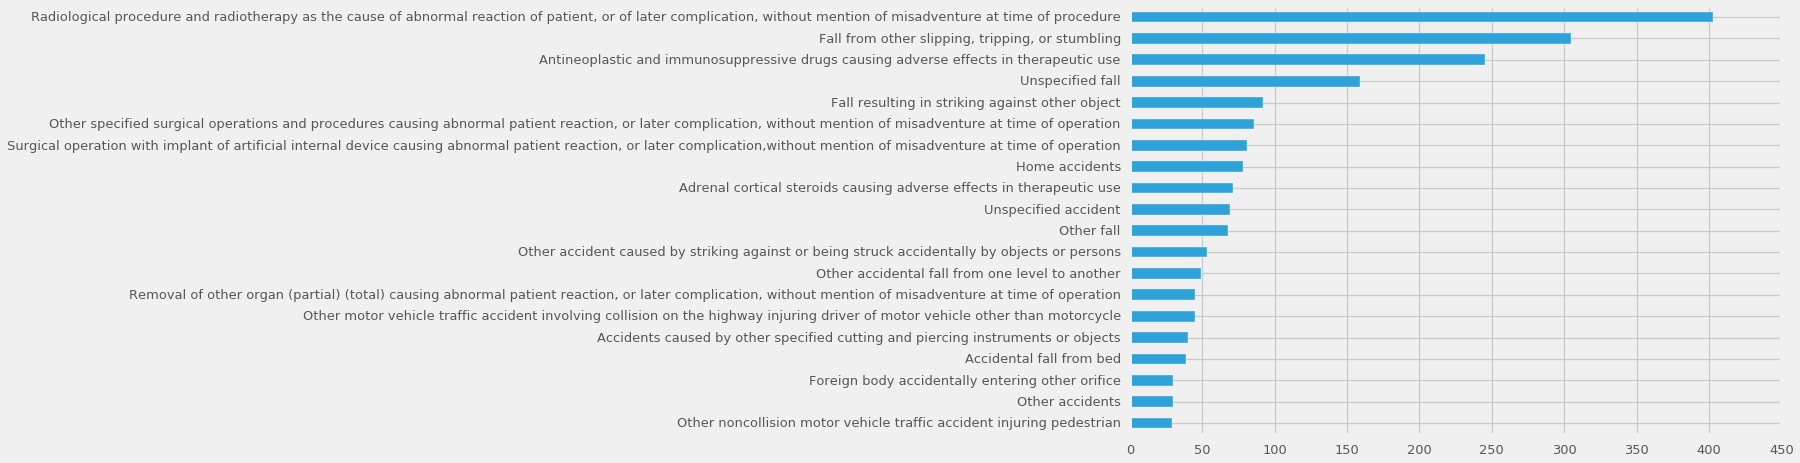

In [149]:
dhcontrol['edgnsd1_description'].value_counts()[:20][::-1].plot(kind='barh')

In [150]:
dhcontrol['edgnsd1_description'].value_counts()[:20][::-1].index

Index(['Other noncollision motor vehicle traffic accident injuring pedestrian',
       'Other accidents', 'Foreign body accidentally entering other orifice',
       'Accidental fall from bed',
       'Accidents caused by other specified cutting and piercing instruments or objects',
       'Other motor vehicle traffic accident involving collision on the highway injuring driver of motor vehicle other than motorcycle',
       'Removal of other organ (partial) (total) causing abnormal patient reaction, or later complication, without mention of misadventure at time of operation',
       'Other accidental fall from one level to another',
       'Other accident caused by striking against or being struck accidentally by objects or persons',
       'Other fall', 'Unspecified accident',
       'Adrenal cortical steroids causing adverse effects in therapeutic use',
       'Home accidents',
       'Surgical operation with implant of artificial internal device causing abnormal patient reaction, or 

In [151]:
import textwrap

In [154]:
print(textwrap.fill(list(dhcontrol['edgnsd1_description'].value_counts()[:20][::-1].index)[-1], width=50))

Radiological procedure and radiotherapy as the
cause of abnormal reaction of patient, or of later
complication, without mention of misadventure at
time of procedure


In [165]:
control_wrapped = [textwrap.fill(i,
width=70) for i in list(dhcontrol['edgnsd1_description'].value_counts()[:20].index)]

In [166]:
control_wrapped

['Radiological procedure and radiotherapy as the cause of abnormal\nreaction of patient, or of later complication, without mention of\nmisadventure at time of procedure',
 'Fall from other slipping, tripping, or stumbling',
 'Antineoplastic and immunosuppressive drugs causing adverse effects in\ntherapeutic use',
 'Unspecified fall',
 'Fall resulting in striking against other object',
 'Other specified surgical operations and procedures causing abnormal\npatient reaction, or later complication, without mention of\nmisadventure at time of operation',
 'Surgical operation with implant of artificial internal device causing\nabnormal patient reaction, or later complication,without mention of\nmisadventure at time of operation',
 'Home accidents',
 'Adrenal cortical steroids causing adverse effects in therapeutic use',
 'Unspecified accident',
 'Other fall',
 'Other accident caused by striking against or being struck accidentally\nby objects or persons',
 'Other accidental fall from one lev

In [167]:
control_crazy = pd.Series(dhcontrol['edgnsd1_description'].value_counts()[:20].values, index=control_wrapped)

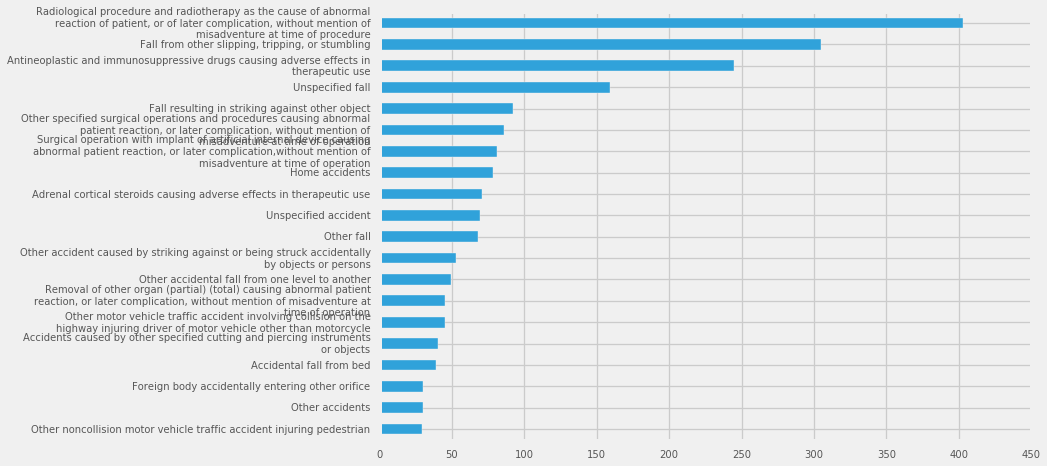

In [211]:
control_crazy[::-1].plot(kind='barh',width=.5,
                        fontsize=10)

    
#tickpositions = (0,2,4,6,8,10,12,14,16,18,20,
#                22,24,26,28,30,32,34,36,38)

#plt.barh(tickpositions, control_crazy.values)
#ticklabels = control_crazy.index

#plt.yticks(tickpositions, ticklabels)
    
#plt.yticks((0,1,2,3,4,5,6,7,8,9,10,
#           11,12,13,14,15,16,17,18,19),
#          tuple(control_crazy[::-1].index))

#plt.tight_layout()
#ax.xaxis.set_major_locator(control_crazy_yticks)
#ax.xaxis.set_tick_params(pad=25)

In [212]:
dhtreatment['edgnsd1_description'].value_counts()

Antineoplastic and immunosuppressive drugs causing adverse effects in therapeutic use                                                                                          898
Radiological procedure and radiotherapy as the cause of abnormal reaction of patient, or of later complication, without mention of misadventure at time of procedure           499
Fall from other slipping, tripping, or stumbling                                                                                                                               240
Unspecified accident                                                                                                                                                           173
Other specified procedures as the cause of abnormal reaction of patient, or of later complication, without mention of misadventure at time of procedure                        169
Unspecified fall                                                                                         